## Importação do [dataset do Kaggle](https://www.kaggle.com/datasets/steubk/wikiart)

In [ ]:
import keras

In [ ]:
# instalação da lib do Kaggle (kagglehub) para realizar download
# !pip install kagglehub

In [ ]:
# imports utilizados no código
import kagglehub
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil

In [ ]:
path = kagglehub.dataset_download("steubk/wikiart")
print("Path to dataset files:", path) # Path to dataset files: /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1

In [ ]:
# classes.csv
path = '/root/.cache/kagglehub/datasets/steubk/wikiart/versions/1/'
dataset_path = os.path.join(path, 'classes.csv')
df = pd.read_csv(dataset_path)

## Exploração do dataset, suas colunas e informações

In [ ]:
df.head()

In [ ]:
df.info(), df.columns

In [ ]:
df['subset'].value_counts()

In [ ]:
df['artist'].value_counts()

In [ ]:
# df['genre'].value_counts().tail(25)
df['genre'].value_counts()

In [ ]:
# # para reconhecer que há mais de uma classificação na instância: apresentar caractere vírgula

# # verifica presença de vírgula para cada instância do df
# result = df['genre'].apply(lambda x: ',' in x)
# # inverte os resultados (quando há vírgula, temos False; quando não há vírgula, temos True)
# df = df[~result] # novo df apresenta instâncias com uma classificação apenas

## Preparação do Dataset

A distribuição das classes está desbalanceada. Para não gerar overfitting no modelo, vamos equilibrar as quantidades de instâncias das classes.

Uso de Augmentation Transforms.

In [ ]:
df.reset_index(drop=True, inplace=True)

# separação do dataset para treinamento e teste
df_train = df[df['subset'] == 'train']
df_test = df[df['subset'] == 'test']

count_values = df_train['genre'].value_counts()
keys = []
values = []

# chaves e valores guardados em listas
for key, value in count_values.items():
  keys.append(key)
  values.append(value)

# visualizando graficamente

fig, ax = plt.subplots()
# nomes das classes no eixo x; quantidades das instâncias dessas classes no eixo y
ax.bar(keys, values)
# configura rotação dos nomes para melhorar legibilidade
plt.xticks(rotation=50, ha='right')
plt.show() # exibe

# quantidades de instâncias das classes muito diferentes

## Usando Keras

In [ ]:
# importação das bibliotecas do Keras e TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import keras

### Dataset a partir dos dados

#### Exclusão de instâncias com mais de uma classificação

In [ ]:
# vamos retirar algumas das classes que apresentam poucas instâncias de dados
# Fauvism, Pointillism, Contemporary Realism, New Realism, Synthetic Cubism, Analytical Cubism, Action painting

# a retirada das classes é feita antes da captura do dataset a partir do diretório

list_directory = os.listdir(path)
print(len(list_directory), list_directory)

# essas classes apresentam poucas instâncias, o que inviabiliza a inclusão destas no treinamento do modelo (quantidade de instâncias insuficiente)
direc_remove = ['Pointillism', 'Contemporary_Realism', 'New_Realism', 'Synthetic_Cubism', 'Analytical_Cubism', 'Action_painting']

# exclusão de outras classes
direc_remove = direc_remove + ['Impressionism', 'Realism', 'Romanticism', 'Post_Impressionism', 'Expressionism', 'Symbolism', 'Art_Nouveau_Modern', 'Baroque',
                               'Abstract_Expressionism', 'Northern_Renaissance', 'Naive_Art_Primitivism', 'Rococo', 'Cubism', 'Color_Field_Painting', 'High_Renaissance',
                               'Mannerism_Late_Renaissance']

for folder in direc_remove:
  folder_path = os.path.join(path, folder)
  try:
    if os.path.isdir(folder_path):
      shutil.rmtree(folder_path)
      print('Removed: ', path + folder, end='. ')
  except Exception as e:
    print('Error: failed', path + folder, end='. ')

list_directory = os.listdir(path)
print()
print(len(list_directory), list_directory)

In [ ]:
# renaissance = ['Mannerism_Late_Renaissance', 'Early_Renaissance', 'High_Renaissance']
# renaissance_dir = path

In [ ]:
# retirada de imagens com mais de uma classificação
# exclusão desses dados é feita no sistema (antes de carregamento dos dados para um dataset)

for _, instance in df.iterrows():
  file_path = str(instance['filename'])
  image_classes = str(instance['genre'])
  # print(image_classes.find(','))
  # busca uma vírgula na string das classes da pintura
  if (image_classes.find(',') != -1):
    # encontrou vírgula
    file_path = os.path.join(path, file_path)
    try:
      os.remove(file_path)
      print('Removed: ', file_path)
    except Exception as e:
      print('Error: failed', file_path)

In [ ]:
train_data, val_data = keras.utils.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(220, 220),
    shuffle=True,
    seed=49,
    validation_split=0.2,
    subset='both',
    interpolation="bilinear",
    data_format=None,
    verbose=True,
)

train_data, val_data, train_data.class_names

In [ ]:
# # retirada de imagens que apresentam mais de uma classificação
# from tensorflow import reduce_sum

# def filter_classes(image, label):
#   # classes estão codificadas com one hot encoding
#   # assim, conta quantos 1's estão presentes na classificação de uma imagem
#   count_classes = reduce_sum(label)
#   # verifica se o contador de classes é igual a 1 e retorna True ou False
#   return tf.equal(count_classes, 1)

# # realiza unbatch do dataset; assim, as imagens são percorridas e o filtro é aplicado individualmente a cada imagem
# unbatch_train_data = train_data.unbatch()

# # aplica filtro
# filtered_train_data = unbatch_train_data.filter(filter_classes)

# # retorna ao formato de batches
# batch_size = 32
# filtered_train_data = filtered_train_data.batch(batch_size)
# filtered_train_data

In [ ]:
# from collections import defaultdict
# import tensorflow as tf

# # Conta as instâncias por classe
# groups = defaultdict(int)

# for image, label in train_data:
#   # retorna as classes das 32 imagens do batch atual
#   classes_images = tf.argmax(label, axis=1).numpy() # transforma o array para um objeto numpy
#   # percorre os 32 valores do array (em que cada um representa a classe de uma imagem)
#   for one_class in classes_images:
#     groups[one_class] += 1 # incrementa o contador para a classe

# # verifica qual das classes apresenta menor quantidade de instâncias; salva esse número de instâncias em number_samples
# number_samples = min(groups.values())
# groups, number_samples

In [ ]:
# grouped_data = defaultdict(list)

# for image, label in train_data:
#     classes_images = tf.argmax(label, axis=1).numpy()
#     for img, cls in zip(image.numpy(), classes_images):
#         grouped_data[cls].append(img)

# # Realize o downsampling
# balanced_images = []
# balanced_labels = []

# for cls, images in grouped_data.items():
#     selected_images = np.random.choice(len(images), number_samples, replace=False)
#     for idx in selected_images:
#         balanced_images.append(images[idx])
#         balanced_labels.append(cls)

# num_classes = max(balanced_labels) + 1

# # Converta os dados para tensores
# balanced_images = tf.convert_to_tensor(balanced_images)
# balanced_labels = tf.keras.utils.to_categorical(balanced_labels, num_classes=num_classes)

# # Crie um novo dataset com os dados balanceados
# balanced_dataset = tf.data.Dataset.from_tensor_slices((balanced_images, balanced_labels))
# balanced_dataset, len(balanced_dataset)

In [ ]:
# from collections import defaultdict
# import tensorflow as tf

# # Conta as instâncias por classe
# groups = defaultdict(int)

# for image, label in train_data:
#   # retorna as classes das 32 imagens do batch atual
#   classes_images = tf.argmax(label, axis=1).numpy() # transforma o array para um objeto numpy
#   # percorre os 32 valores do array (em que cada um representa a classe de uma imagem)
#   for one_class in classes_images:
#     groups[one_class] += 1 # incrementa o contador para a classe

# # verifica qual das classes apresenta menor quantidade de instâncias; salva esse número de instâncias em number_samples
# number_samples = min(groups.values())
# groups, number_samples

# # defaultdict(int,
# # 		             {1: 3470,
# # 		              7: 1082,
# # 		              6: 5370,
# # 		              14: 5170,
# # 		              3: 1307,
# # 		              17: 5596,
# # 		              15: 8612,
# # 		              8: 10484,
# # 		              18: 3588,
# # 		              10: 1082,
# # 		              4: 1783,
# # 		              5: 1110,
# # 		              2: 3352,
# # 		              0: 2238,
# # 		              9: 1049,
# # 		              11: 1914,
# # 		              13: 1183,
# # 		              12: 2037,
# # 		              16: 1659,
# # 		              19: 937}),
# # 		 937

In [ ]:
# # retirada de imagens que apresentam mais de uma classificação
# from tensorflow import reduce_sum

# def filter_classes(image, label):
#   # classes estão codificadas com one hot encoding
#   # assim, conta quantos 1's estão presentes na classificação de uma imagem
#   count_classes = reduce_sum(label)
#   # verifica se o contador de classes é igual a 1 e retorna True ou False
#   return tf.equal(count_classes, 1)

# # realiza unbatch do dataset; assim, as imagens são percorridas e o filtro é aplicado individualmente a cada imagem
# unbatch_train_data = train_data.unbatch()

# # aplica filtro
# filtered_train_data = unbatch_train_data.filter(filter_classes)

# # retorna ao formato de batches
# batch_size = 32
# filtered_train_data = filtered_train_data.batch(batch_size)
# filtered_train_data

In [ ]:
# os códigos comentados abaixo atingiram limite da memória RAM e não serão utilizados

# # criação de arrays para dados de treinamento e validação

# num_images = len(df_train)
# train_data = np.zeros((num_images, 224, 224, 3), dtype=np.float32)
# path = '/root/.cache/kagglehub/datasets/steubk/wikiart/versions/1'

# # a partir do filename do dataframe, pegamos o arquivo da imagem, abrimos, fazemos redimensionamento e transformamos em array
# for i in range(num_images):
#   filename = df_train.iloc[i]['filename']
#   try:
#     img = tf.keras.preprocessing.image.load_img(path + '/' + filename, target_size=(224, 224))
#     train_data[i] = tf.keras.preprocessing.image.img_to_array(img)
#   except Exception as e:
#     print('Erro - ', path + '/' + filename, e)

# train_data[:5]

# num_images = len(df_test)
# val_data = np.zeros((num_images, 224, 224, 3), dtype=np.float32)

# for i in range(num_images):
#   filename = df_test.iloc[i]['filename']
#   try:
#     img = tf.keras.preprocessing.image.load_img(path + '/' + filename, target_size=(224, 224))
#     val_data[i] = tf.keras.preprocessing.image.img_to_array(img)
#   except Exception as e:
#     print('Erro - ', path + '/' + filename, e)

# val_data[:5]

# my_dict = df_train['genre'].value_counts().to_dict()

# list_classes = []
# for i in my_dict.keys():
#   string = str(i)
#   list_classes.append(string)

# # ---

# from sklearn.preprocessing import LabelEncoder
# label_enc = LabelEncoder()
# label_enc.fit(list_classes)
# label_enc.transform(list_classes)

# train_labels = []

# for i in range(len(df_train)):
#   label = label_enc.transform([str(df_train['genre'][i])])
#   train_labels.append(label)

# train_labels

# val_labels = []

# for i in range(len(df_train)):
#   label = label_enc.transform([str(df_train['genre'][i])])
#   val_labels.append(label)

# val_labels

## Modelo CNN - Usando Keras

In [ ]:
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential

# num_classes = len(train_data.class_names)

# VERSÃO 1
# model = Sequential([
#   layers.Rescaling(1./255, input_shape=(220, 220, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

# model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential

# num_classes = len(train_data.class_names)

# # VERSÃO 2
# data_augmentation = keras.Sequential(
#   [
#     layers.RandomFlip("horizontal",
#                       input_shape=(220,
#                                   220,
#                                   3)),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1),
#   ]
# )

# model = Sequential([
#   data_augmentation,
#   layers.Rescaling(1./255),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2),
#   layers.Conv2D(128, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(128, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(128, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes, name="outputs", activation='softmax')
# ])

# model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

num_classes = len(train_data.class_names)

# VERSÃO 3
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(220, 220, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2),
  layers.RandomContrast(0.2),
  ]
)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),

  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes, name="outputs", activation='softmax')
])

model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

epochs=14

early_stopping = EarlyStopping(
    monitor="val_loss",  # Métrica monitorada
    patience=3,          # Número de épocas sem melhoria antes de parar
    restore_best_weights=True,  # Restaura os pesos do melhor modelo
    verbose=1            # Exibe mensagens no console
)

history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[early_stopping]
)

In [ ]:
predict_label = model.predict(val_data, batch_size=32)

In [ ]:
predict_label = np.argmax(predict_label, axis=1)

In [ ]:
predict_label, len(predict_label)

In [ ]:
def extract_label(image, label):
  return label

labels = val_data.map(extract_label)
true_label = [label.numpy() for label in labels]

In [ ]:
true_label = np.argmax(true_label, axis=1)

In [ ]:
true_label, len(true_label)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(true_label, predict_label)

In [ ]:
from sklearn.metrics import classification_report

target_names = ['Early_Renaissance', 'Fauvism', 'Minimalism', 'Pop_Art', 'Ukiyo_e']

print(classification_report(true_label, predict_label, target_names=target_names))

In [ ]:
model.save_weights("model.weights.h5")

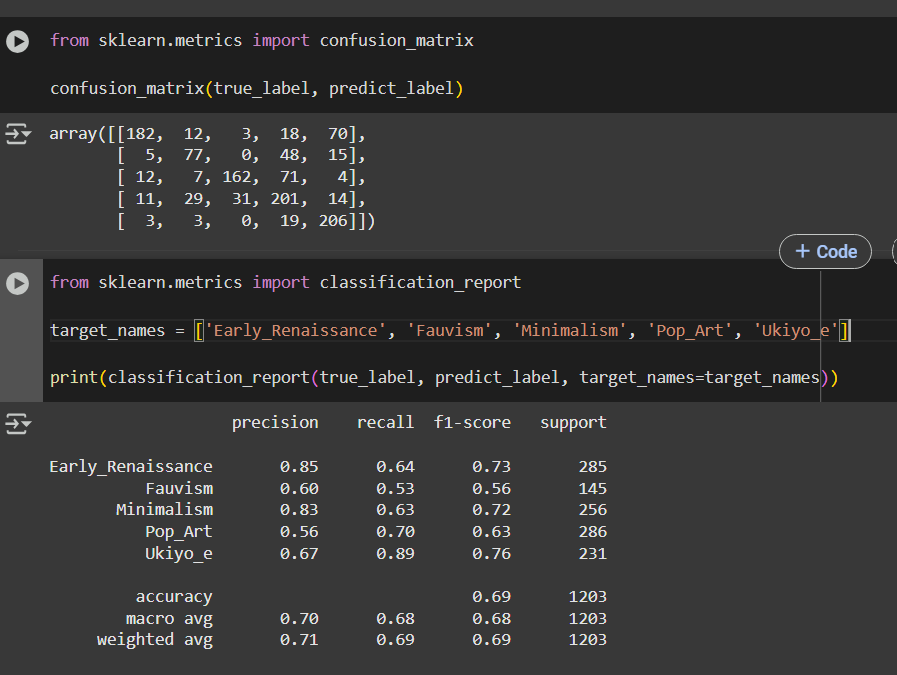

In [ ]:
model.load_weights('model_5_classes.weights.h5')

In [ ]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

# target_names = ['Early_Renaissance', 'Fauvism', 'Minimalism', 'Pop_Art', 'Ukiyo_e']

# image_path = '/content/ukiyo-e.jpeg' # array([4]) Ukiyo_e
# image_path = '/content/early-renaissance.jpeg' # array([0]) Early_Renaissance
# image_path = '/content/fauvism.jpg' # array([1]) Fauvism
# image_path = '/content/arte-minimalista-2-5.jpeg' # array([3]) Pop_Art ERRADO
# image_path = '/content/arte-minimalista-3-5.jpeg' # array([3]) Pop_Art ERRADO
# image_path = '/content/renaissance.jpeg' # array([4]) Ukiyo_e ERRADO
image_path = ''

img = load_img(image_path, target_size=(220, 220))

img_array = img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)
predicted_class

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

## [Computer Vision Course - Hugging Face](https://huggingface.co/learn/computer-vision-course/en/unit0/welcome/welcome)

### Contextualização e introdução a elementos básicos de Visão Computacional

##### Introdução

- A visão humana trabalha com a 'entrada' de uma imagem e extração de informações dessa entrada. Visão Computacional é uma tarefa semelhante, mas pode ser muito mais abrangente!
- Como é o reconhecimento de bolas usadas em esportes (humanos X computadores)? Essa é uma tarefa que envolve uma análise do contexto geral em que essa bola está inserida, e a classificação exata depende muito do local em que essa bola está inserida, e é aí que entra o uso de Inteligência Artificial!
- O uso de programação pura para realizar uma detecção desse tipo é muito difícil, pois o contexto é muito significativo nessa questão (e em várias outras). Em tarefas assim, existe a necessidade de sistemas mais robustos. Por isso Visão Computacional está estreitamente relacionada a IA!

##### Imagens

- Imagens como funções de N dimensões; pensando em 2 dimensões, cada par de coordenadas xi, yi é um elemento da imagem (pixel, picture element) e a amplitude de F para essa coordenad indica o nível de cinza no ponto. Pensando em cores, cada canal da imagem é uma diferente componente de cor dessa imagem e temos um F pra cada componente de cor (referenciando F(x, y)). Também há outros tipos de imagem em que a função F traz um label para os pixels.
- Comumente, os computadores 'visualizam' imagens como matrizes (um array numérico de duas dimensões)!
- Vídeos: adicionamos uma terceira dimensão à função F e incluímos a dimensão do tempo (F(x, y, t)).

...


---

### Redes Neurais Convolucionais (Convolutional Neural Networks - CNNs)

##### Convolução
- Convolução: uma janela com números que atravessa os dados e realiza uma multiplicação e soma desses valores; o resultado desse filtro é a taxa de variação dos dados (derivada!). Essa ideia é a base dos filtros em PDI (filtro de Prewitt, Sobel etc.).

##### CNNs
- A ideia é utilizar filtros para extrair informações de imagens e, como alguns filtros funcionam melhor ou pior com certas imagens, definir os filtros ótimos que conseguem extrair informações importantes
- Muitas vezes, interessa-nos apenas as bordas detectadas em uma imagem. Assim, para 'resumir' uma imagem, realizamos 'pooling' e temos menos parâmetros e ainda assim temos as informações necessárias para trabalhar. Assim, pooling é a operação de obter o elemento de valor mais importante no feature map.